<a href="https://colab.research.google.com/github/Guo0911/generative_ai/blob/main/%5BGenerative_AI%5D_Homework_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **打造自己的圖像生成Web App!**
## 風格：**浮世繪風格**

浮世繪（Ukiyo-e）是起源於日本江戶時代（17-19世紀）的傳統木版畫藝術形式。這種風格以其精緻的線條、平面化的構圖、鮮明的色彩區塊和獨特的透視法而聞名。

代表藝術家包括葛飾北齋（Katsushika Hokusai）、歌川廣重（Utagawa Hiroshige）和喜多川歌麿（Kitagawa Utamaro）。

浮世繪常描繪自然風景、花鳥、名勝古蹟、歷史人物和日常生活場景，以細膩的線條和和諧的色彩表現出深厚的東方美學底蘊。最著名的作品之一是葛飾北齋的《神奈川衝浪裡》（又稱《大波》）。

生成圖片用的模型是 [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)

以下是我透過上面的資訊讓 Claude 幫我撰寫的參數和 prompt，可以看出模型有理解意思

但我認為可能是因為相關的訓練資料比較少，導致模型的表現不太理想。

default_enhance:

```
masterpiece, ukiyo-e style, traditional Japanese woodblock print, fine line art, flat color blocks, harmonious color palette, elegant composition, authentic Japanese aesthetics, detailed traditional patterns, woodblock texture
```
default_negative:

```
western art style, realistic shading, 3D rendering, photographic style, gradient colors, modern lighting effects, messy lines, unbalanced composition, non-Japanese elements, low quality, blurry details
```

---

### 四組 prompt 和生成的圖片：

1. prompt：Ukiyo-e artwork in Hokusai's style, depicting a samurai standing on a broken bridge gazing at turbulent ocean waves, with wave crests curling like claws, Mount Fuji faintly visible in the distance, deep blue sky, traditional woodblock print line texture, scattered falling cherry blossom petals adorning the negative space of the composition
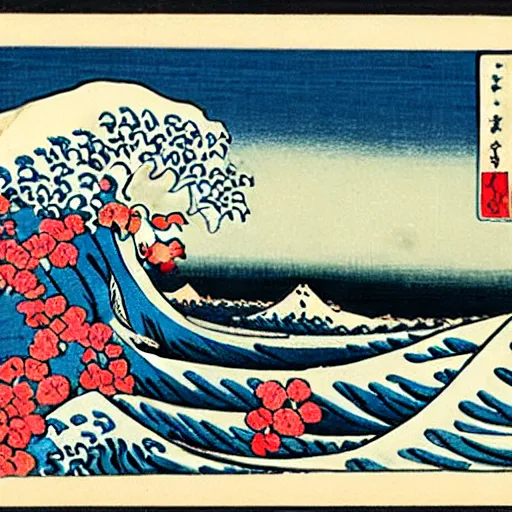

2. Ukiyo-e in Utagawa Hiroshige's style, nighttime street scene in the rain, geisha walking under paper umbrellas on stone-paved roads, lantern light filtering through rain curtains, unique perspective composition, prominent woodblock print texture, dominated by blue and deep brown tones, framed with traditional Japanese decorative border patterns
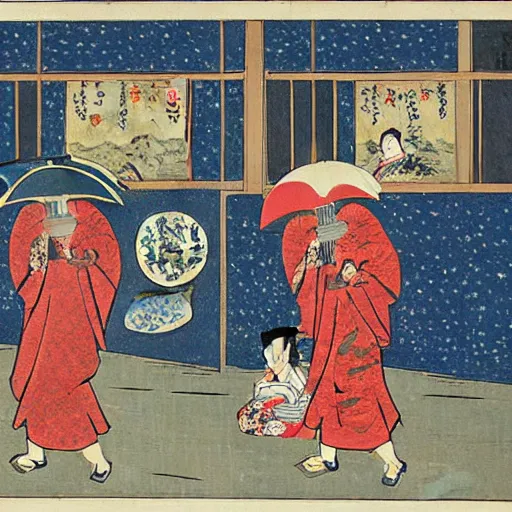

3. Ukiyo-e in Kitagawa Utamaro's style, spring tea garden harvesting scene, farmers bending to work, rolling mountains and misty clouds in the distance, blooming plum trees in the foreground, color palette dominated by greens and earth tones, delicately depicted facial expressions and gestures, traditional woodblock print texture with Japanese calligraphic inscriptions
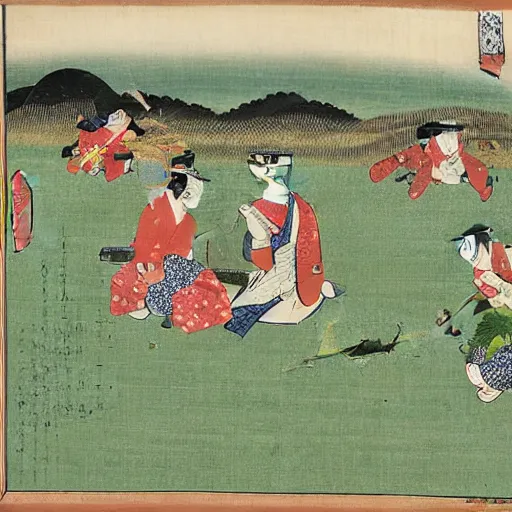

4. Ukiyo-e in Tsukioka Yoshitoshi's style, depicting traditional Noh theater performance scene, performer wearing demon mask with exaggerated dynamic poses, minimalist stage illuminated by candlelight in the background, silhouettes of audience visible, bold red and black contrasting colors, sharp and powerful line work, intense dramatic tension and mysterious atmosphere, bordered with Japanese calligraphy and seals              
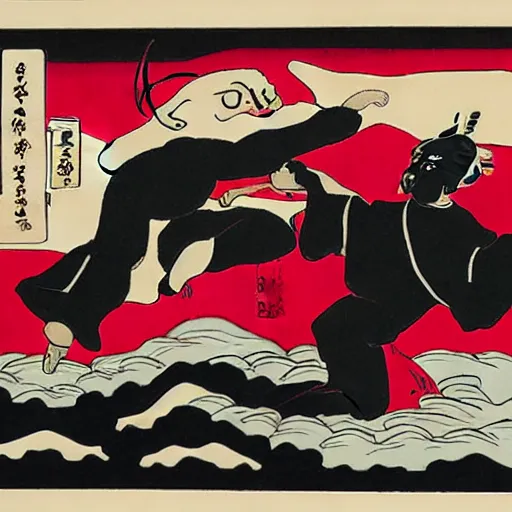

# 📚 打造 Stable Diffusion 的 WebUI

### 1. 安裝必要套件

In [1]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8

In [2]:
# from google.colab import userdata

# hf_token = userdata.get("HuggingFace")
# login(token=hf_token)

In [3]:
import gc
import torch
import random

import gradio as gr
import matplotlib.pyplot as plt

from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler

### 2. 指定並讀入模型

In [4]:
model_name = "CompVis/stable-diffusion-v1-4"

注意有可能要停用 `use_safetensors=True`。

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### 3. 生成的函式

In [6]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = []
    negative_prompts = []
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

### 4. 打造 Gradio Web App

In [7]:
default_enhance = "masterpiece, ukiyo-e style, traditional Japanese woodblock print, fine line art, flat color blocks, harmonious color palette, elegant composition, authentic Japanese aesthetics, detailed traditional patterns, woodblock texture"
default_negative = "western art style, realistic shading, 3D rendering, photographic style, gradient colors, modern lighting effects, messy lines, unbalanced composition, non-Japanese elements, low quality, blurry details"

with gr.Blocks(css=".gradio-container {background-color: #FAFAFA; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #667eea, #764ba2); color: white;}") as demo:
    gr.Markdown("""
    # 🎨 互動圖像生成器
    輸入提示詞，立即生成你的寫實風格作品！
    """)

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="Prompt", placeholder="請輸入你的提示詞 (prompt)", lines=3)
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容", value=default_enhance)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt 內容", value=default_negative)
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed (選填)", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度 Height", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度 Width", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, value=20, step=5, label="生成步數 (Steps)")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            generate_btn = gr.Button("🚀 開始生成！")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Random Seeds")

    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images],
        outputs=[gallery, seed_info]
    )

In [ ]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0a9776cd3e06a52ab5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Token indices sequence length is longer than the specified maximum sequence length for this model (274 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['海 浪 ， 浪 花 如 爪 般 捲 曲 ， 遠 處 富 士 山 若 隱 若 現 ， 天 空 呈 深 藍 色 調 ， 有 傳 統 木 版 畫 的 線 條 質 感 ， 畫 面 留 白 處 點 綴 飄 落 的 櫻 花 瓣 , masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['海 浪 ， 浪 花 如 爪 般 捲 曲 ， 遠 處 富 士 山 若 隱 若 現 ， 天 空 呈 深 藍 色 調 ， 有 傳 統 木 版 畫 的 線 條 質 感 ， 畫 面 留 白 處 點 綴 飄 落 的 櫻 花 瓣 , masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['masterpiece , ukiyo - e style , traditional japanese woodblock print , fine line art , flat color blocks , harmonious color palette , elegant composition , authentic japanese aesthetics , detailed traditional patterns , woodblock texture']


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
